# EDEN NOTEBOOK # 3: SOC Code Recommender Model Generator

## Welcome note:

Wecome to the **SOC Code Recommender Model Generator!** The contents of this notebook will lead the user through the training and pickling of the SOC Code Recommender Model using a Naive Bayes classifier with a count vector as our features. 

#### What are Count Vectors as features?
Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

## Getting your machine ready

Lets implement basic components in a step by step manner in order to create a text classification framework in python. To start with, import all the required libraries.

You would need requisite libraries to run this code – you can install them using pip install x (for example: pip install Pandas) frm the command prompt.

- Pandas
- Scikit-learn
- Numpy

In [1]:
# libraries for dataset preparation, feature engineering, model training 

# For basic data wrangling 
import pandas as pd
import numpy as np

# To load the model and vectorizor
import pickle

# For text processing
import nltk

# For modeling
from sklearn import model_selection, preprocessing, naive_bayes
from sklearn.feature_extraction.text import CountVectorizer

# For reporting how how each cell takes to run
import time

#set up print formating specifications:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
    
print("All libraries were successfully imported")

All libraries were successfully imported


## Assign Appropriate Paths or import data from S3

In [2]:
# User's Location of git repository
Git_Location = 'C:/Users/583621/OneDrive - Booz Allen Hamilton/Billable Projects/DOL/DAC/SOC Code Use Case/'

# Set Data Location:
FLAG_data = Git_Location + 'NLP_usecase_data_10000/Job_description_top10000.csv' 

# Set model location:
saved_soc_rec_model = Git_Location + 'saved_soc_rec_model.sav'

# Set vectorizor location:
pickled_vectorizor = Git_Location + 'fit_vector.pickle'

# Set Onet Occupations list
ONET_data = Git_Location + 'NLP_usecase_data_10000/ONET_2010_Occupations.csv' 

# 1. Import Data

To prepare the dataset, load the downloaded data into a pandas dataframe containing two columns – text and label. (Source)


## 1.1 Import FLAG Data

In [3]:
%%time

# load the FLAG data
raw_df = pd.read_csv(FLAG_data,low_memory=False,thousands=',', encoding='latin-1')
df = raw_df[['SOC_CODE','JOB_DUTIES']]
df = df.rename(columns={"SOC_CODE": "label", "JOB_DUTIES": "text"})

print(" ")
print("Job description data was successfully imported")
# print(color.BOLD + "Quick preview of the data:" + color.END)
# print(df.head())
# print(" ")
# print(color.BOLD + "Here is what one full job description looks like (sample):" + color.END)
# print("")
# print(df.iloc[733,1])

 
Job description data was successfully imported
Wall time: 72.9 ms


## 1.2 Import ONET Occupation Data

We use this to label the SOC Coes

In [4]:
%time
# load the FLAG data
raw_onet = pd.read_csv(ONET_data,low_memory=False,thousands=',', encoding='latin-1')
onet = raw_onet.rename(columns={"O*NET-SOC 2010 Code": "SOC_CODE", "O*NET-SOC 2010 Title": "R_SOC_TITLE","O*NET-SOC 2010 Description":"R_SOC_DESCRIPTION"})

#Convert label to float
onet['SOC_CODE']=onet['SOC_CODE'].str.replace('-', '',regex=True, case = False).str.strip()
onet['SOC_CODE']=onet['SOC_CODE'].astype('float64', raise_on_error = False) # convert soc codes to floats

print(" ")
print("SOC labels were successfully imported")
# print(onet.head())
# print(" ")
# print(onet.dtypes)

Wall time: 0 ns
 
SOC labels were successfully imported


## Cleaning

Next we need to clean the training dataset. As you can see above, there are a lot of special chacters, numbers, and white space. We need to remove all of those to ensure that it does not affect the model.

In [5]:
%%time
#clean

# Remove white space and slashes
df['text']=df['text'].str.replace('\n', ' ',regex=True, case = False).str.strip()
df['text']=df['text'].str.replace('\s+', ' ',regex=True, case = False)
df['text']=df['text'].str.replace('/', ' ',regex=True, case = False).str.strip()

# lower case everything
df['text']=df['text'].str.lower()

#Remove stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
#stop_words = ('ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than')
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#Convert label to float
df['label']=df['label'].str.replace('-', '',regex=True, case = False).str.strip()
df['label']=df['label'].astype('float64', raise_on_error = False)

#eliminate all other characters/numbers except alphas and spaces
list1 = []
whitelist = set('abcdefghijklmnopqrstuvwxyz ABCDEFGHIJKLMNOPQRSTUVWXYZ')
for index, row in df.iterrows():
    list1.append(''.join(filter(whitelist.__contains__, row['text'])).strip())
    
newdf = pd.DataFrame({'text clean':list1})
df = df.reset_index()
df = pd.merge(df, newdf, left_index=True, right_index=True)

#rename the soc des str var
df = df[['label','text clean']]
df['text'] = df['text clean']
df = df[['label','text']]

#Remove none english words
words = set(nltk.corpus.words.words())
df['text'] = df['text'].apply(lambda x: ' '.join([w for w in nltk.wordpunct_tokenize(x) if w.lower() in words or not w.isalpha()]))


# Validate
# print(color.BOLD + "Total row/col count:" + color.END, df.shape)
# print(" ")
# print(color.BOLD + "Data Types:" + color.END)
# print(df.dtypes)
# print(" ")
# print(color.BOLD + "Quick preview of the cleaned data:" + color.END)
# print(df.head())
# print(" ")
# print(color.BOLD + "Now the same full clean job description (sample):" + color.END)
# print("")
# print(df.iloc[733,1])

print(" ")
print("Job Description data was successfully cleaned")

 
Job Description data was successfully cleaned
Wall time: 1.68 s


# 2. Feature Engineering

The next step is the feature engineering step. In this step, raw text data will be transformed into feature vectors and new features will be created using the existing dataset. We will implement the following different ideas in order to obtain relevant features from our dataset. For this use case we will use **count vectors as features** since it proved to perform the best. 

## What are Count Vectors as features? 

Count Vector is a matrix notation of the dataset in which every row represents a document from the corpus, every column represents a term from the corpus, and every cell represents the frequency count of a particular term in a particular document.

Like this:

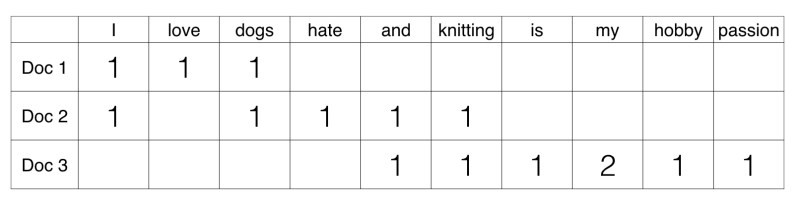

In [6]:
# %time
# # If you need to, refresh the model here:
# %run ./SOC_Code_Recommended_Final_Model_Production.ipynb

In [7]:
%time
# Load the vectorizor
fit_vectorizor = pickle.load(open(pickled_vectorizor, 'rb'))
print(" ")
print("The model's vectorizor was successfully imported")

# Vectorize the data using a saved vectorizor
xtrain_count =  fit_vectorizor.transform(df['text'])

print(" ")
print("Job description data was successfully vectorized")

Wall time: 0 ns
 
The model's vectorizor was successfully imported
 
Job description data was successfully vectorized


In [8]:
df.head()

,label,text
0,192031.0,perform bench work senior chemist level conduc...
1,151133.0,design engineer implement maintain quantitativ...
2,152041.0,design develop modify evaluate data management...
3,131111.0,manage design development business achieve sup...
4,312021.0,assist physical therapist rehabilitative impro...


# 3. Load Saved Model

The next step in the text classification framework is to load our classifier using the features created in the previous step. There are many different choices of machine learning models which can be used to train a final model. We will implement a Naive Bayes Classifier as it preformed the best. 

#### What is a Naive Bayes Classifier?

Naive Bayes is a classification technique based on Bayes’ Theorem with an assumption of independence among predictors. A Naive Bayes classifier assumes that the presence of a particular feature in a class is unrelated to the presence of any other features.

For more info please visit: https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

In [9]:
%time
# load the model and vectorizor from disk
soc_rec_model = pickle.load(open(Git_Location + 'soc_rec_model.sav', 'rb'))

print(" ")
print("The model was successfully loaded")

Wall time: 0 ns
 
The model was successfully loaded


In [10]:
# predict on incoming data
def recommend_top_n(model, n, feature_vector, df):
    
    '''
    This function assumes that the job description field has already been vectorized
    User needs to decide how many soc codes they want to produce with n
    
    '''
    
    # predict probailities of all socs on incoming dataset
    probas = model.predict_proba(feature_vector)
    
    #select top n probabilities
    top_n_probas = probas[np.argsort(probas)[-n:]]
    
    #Identify the indexes of the top predictions
    top_n_predictions = np.argsort(probas, axis = 1)[:,-n:]
    
    #then find the associated SOC code for each prediction
    top_class = model.classes_[top_n_predictions]
    
    #cast results to a new dataframe
    top_class_df = pd.DataFrame(data=top_class)
#     top_n_probas_df = pd.DataFrame(data=top_n_probas)
    
    # merge it up with the validation labels and descriptions
    results = pd.merge(raw_df, top_class_df, left_index=True, right_index=True)
    
    #Convert labels to floats to prep for merge
    results[0]=results[0].astype('float64', raise_on_error = False)
    results[1]=results[1].astype('float64', raise_on_error = False)
    results[2]=results[2].astype('float64', raise_on_error = False)
    results[3]=results[3].astype('float64', raise_on_error = False)
    results[4]=results[4].astype('float64', raise_on_error = False)
    
    # Merge all labels
#     results = pd.merge(results, top_class_df, left_index=True, right_index=True)
    results = pd.merge(results, onet, how='left',left_on=[0], right_on=['SOC_CODE'], suffixes=('', '_y')).drop(columns=['SOC_CODE_y']) #soc descriptions 
    results = results.rename(columns={"R_SOC_TITLE": "0_TITLE", "R_SOC_DESCRIPTION": "0_DESCRIPTION"})
    results = pd.merge(results, onet, how='left',left_on=[1], right_on=['SOC_CODE'], suffixes=('', '_y')).drop(columns=['SOC_CODE_y']) #soc descriptions 
    results = results.rename(columns={"R_SOC_TITLE": "1_TITLE", "R_SOC_DESCRIPTION": "1_DESCRIPTION"})
    results = pd.merge(results, onet, how='left',left_on=[2], right_on=['SOC_CODE'], suffixes=('', '_y')).drop(columns=['SOC_CODE_y']) #soc descriptions 
    results = results.rename(columns={"R_SOC_TITLE": "2_TITLE", "R_SOC_DESCRIPTION": "2_DESCRIPTION"})
    results = pd.merge(results, onet, how='left',left_on=[3], right_on=['SOC_CODE'], suffixes=('', '_y')).drop(columns=['SOC_CODE_y']) #soc descriptions 
    results = results.rename(columns={"R_SOC_TITLE": "3_TITLE", "R_SOC_DESCRIPTION": "3_DESCRIPTION"})
    results = pd.merge(results, onet, how='left',left_on=[4], right_on=['SOC_CODE'], suffixes=('', '_y')).drop(columns=['SOC_CODE_y']) #soc descriptions 
    results = results.rename(columns={"R_SOC_TITLE": "4_TITLE", "R_SOC_DESCRIPTION": "4_DESCRIPTION"})

    return results

In [15]:
results = recommend_top_n(soc_rec_model, 5, xtrain_count, df)
results.head()

,CASE_ID,CASE_NUMBER,SUBMIT_DATE,CASE_TYPE,VISA_TYPE,SOC_CODE,SUGGESTED_SOC_CODE,SOC_TITLE,SUGGESTED_SOC_TITLE,EDUCATION_TYPE,...,0_TITLE,0_DESCRIPTION,1_TITLE,1_DESCRIPTION,2_TITLE,2_DESCRIPTION,3_TITLE,3_DESCRIPTION,4_TITLE,4_DESCRIPTION
0,6485755,P-100-18262-652499,19-SEP-18,Prevailing Wage Determination,PERM,19-2031.00,19-2031,Chemists,Chemists,Bachelor's,...,Computer and Information Systems Managers,"Plan, direct, or coordinate activities in such...",Mechanical Engineers,Perform engineering duties in planning and des...,"Software Developers, Systems Software","Research, design, develop, and test operating ...",Computer Systems Analysts,"Analyze science, engineering, business, and ot...","Software Developers, Applications","Develop, create, and modify general computer a..."
1,6269124,P-100-18144-964784,05-OCT-18,Prevailing Wage Determination,PERM,15-1133.00,15-1133,"Software Developers, Systems Software","Software Developers, Systems Software",Bachelor's,...,Statisticians,Develop or apply mathematical or statistical t...,Computer and Information Systems Managers,"Plan, direct, or coordinate activities in such...",Computer Systems Analysts,"Analyze science, engineering, business, and ot...","Software Developers, Systems Software","Research, design, develop, and test operating ...","Software Developers, Applications","Develop, create, and modify general computer a..."
2,6442686,P-100-18239-726517,27-AUG-18,Prevailing Wage Determination,PERM,15-2041.00,15-2031,Statisticians,Operations Research Analysts,Bachelor's,...,Computer and Information Systems Managers,"Plan, direct, or coordinate activities in such...",Statisticians,Develop or apply mathematical or statistical t...,"Software Developers, Systems Software","Research, design, develop, and test operating ...",Computer Systems Analysts,"Analyze science, engineering, business, and ot...","Software Developers, Applications","Develop, create, and modify general computer a..."
3,6471191,P-100-18254-568178,02-OCT-18,Prevailing Wage Determination,PERM,13-1111.00,13-1111,Management Analysts,Management Analysts,Bachelor's,...,"Software Developers, Systems Software","Research, design, develop, and test operating ...",Computer and Information Systems Managers,"Plan, direct, or coordinate activities in such...",Computer Systems Analysts,"Analyze science, engineering, business, and ot...","Software Developers, Applications","Develop, create, and modify general computer a...",Management Analysts,Conduct organizational studies and evaluations...
4,6504876,P-100-18274-358108,01-OCT-18,Prevailing Wage Determination,PERM,31-2021.00,31-2021,Physical Therapist Assistants,Physical Therapist Assistants,Bachelor's,...,Registered Nurses,"Assess patient health problems and needs, deve...",Mechanical Engineers,Perform engineering duties in planning and des...,"Internists, General",Physicians who diagnose and provide non-surgic...,Physical Therapist Assistants,Assist physical therapists in providing physic...,Physical Therapists,"Assess, plan, organize, and participate in reh..."


### Search and print examples of results

In [31]:
# Accept user input:
def query_results():
    print(" ")
    print("Hi!")
    print(" ")
    print("Welcome to the SOC Code Recommender!")
    print(" ")
    case_number = input("Please enter the case number you would like to search for: (ex: 'P-100-18274-358108')") 
    print(" ")
    print("Thank you!")
    
    filtered_results = results[results['CASE_NUMBER'].str.contains(case_number, na=False)]

    print(color.BOLD + color.BLUE +"Case Number:" + color.END, filtered_results.iloc[0,1])
    print("")
    print(color.BOLD +  color.BLUE +"Job Title::" + color.END, filtered_results.iloc[0,12])
    print("")
    # Print OFLC Recommended SOC Code
    print(color.BOLD +  color.BLUE +"SOC Code Recommended by OFLC Analyst:" + color.END,filtered_results.iloc[0,5]," - ",filtered_results.iloc[0,7])
    print("")
#     if filtered_results.iloc[0,5]!="":
#         print(filtered_results.iloc[0,5]," - ",filtered_results.iloc[0,7])
#     else:
#         print("Case not yet determined")
    print("")
    print(color.BOLD +  color.BLUE +"Job Duties:" + color.END)
    print("")
    print(filtered_results.iloc[0,13])
    print("")
    print(color.BOLD +  color.BLUE +"Top 5 SOC Codes Recommended by Model:" + color.END)
    print("")
    print("1. ",color.BOLD + np.array2string(filtered_results.iloc[0,18]) + color.END,": ",filtered_results.iloc[0,27]) # add this script to include the descriptions >>> ," ",filtered_results.iloc[0,28]
    print("2. ",color.BOLD + np.array2string(filtered_results.iloc[0,17]) + color.END,": ",filtered_results.iloc[0,25])  # add this script to include the descriptions >>>  # add this script to include the descriptions >>>
    print("3. ",color.BOLD + np.array2string(filtered_results.iloc[0,16]) + color.END,": ",filtered_results.iloc[0,23])  # add this script to include the descriptions >>> ," ",filtered_results.iloc[0,24]
    print("4. ",color.BOLD + np.array2string(filtered_results.iloc[0,15]) + color.END,": ",filtered_results.iloc[0,21])  # add this script to include the descriptions >>> ," ",filtered_results.iloc[0,22]
    print("5. ",color.BOLD + np.array2string(filtered_results.iloc[0,14]) + color.END,": ",filtered_results.iloc[0,19])  # add this script to include the descriptions >>> ," ",filtered_results.iloc[0,20]

In [32]:
#call it
# query_results()

 
Hi!
 
Welcome to the SOC Code Recommender!
 
Please enter the case number you would like to search for: (ex: 'P-100-18274-358108')123
 
Thank you!
Case Number: P-100-18242-391230

Job Title:: Software Engineer

SOC Code Recommended by OFLC Analyst: 15-1133.00  -  Software Developers, Systems Software


Job Duties:

Utilize independent judgment to design and develop compilers and assemblers, utility programs, and operating systems. Assess and advise on machine characteristics that affect software systems such as storage capacity, processing speed, and input/output requirements. Perform network product design, development, testing, and analysis of software applications. Design, develop, and utilize productivity enhancement layout tools, and design rule checkers and electronic data processing systems software. Duties may include application design, writing of code, programming, as well as development and execution of testing and debugging routines.

In lieu of a Master's Degree + three 

In [14]:
print(" ")
print("Your results are now ready!")
print("They can be accesed by calling on the dataframe 'results' or by simply typing query_results()")
print("into the cell below to search for a particular case number")

 
Your results are now ready!
They can be accesed by calling on the dataframe 'results' or by simply typing query_results()
into the cell below to search for a particular case number
